In [ ]:
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import LanguageParser
from langchain_text_splitters import Language
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI
import os
os.environ["GOOGLE_API_KEY"]=''

In [21]:
loader = GenericLoader.from_filesystem(
    r"D:\my_study\MAS_game",
    glob="**/*",
    suffixes=[".py"],
    exclude=["**/non-utf8-encoding.py"],
    parser=LanguageParser(language=Language.PYTHON, parser_threshold=500),
)
documents = loader.load()
print(len(documents))


11


In [22]:
print(documents[2])

page_content='import numpy as np
import json
from typing import Optional, Dict, Any
from enum import Enum
import time
import asyncio

from game_manager import EnhancedGameManager
from config import GAME_GENRES
from tictactoe import TicTacToe3D
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

async def get_player_move(game_type: str, board=None) -> dict:
    """Get and validate player move based on game type"""
    if game_type == "3D Tic Tac Toe":
        while True:
            try:
                print("\nEnter your move (x y z), each number from 0-2:")
                move = input("> ").strip().split()
                x, y, z = map(int, move)
                if 0 <= x <= 2 and 0 <= y <= 2 and 0 <= z <= 2:
                    return {"type": "move", "position": [x, y, z]}
                print("Invalid coordinates. Please use numbers 0-2.")
            except (ValueError, IndexError):
                print("Invalid input. Please enter th

In [23]:
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=2000, chunk_overlap=200
)
texts = python_splitter.split_documents(documents)
print(len(texts))

59


In [24]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.25,  # 15 requests per minute
    check_every_n_seconds=0.1,  # Check every 100 ms
    max_bucket_size=1  # Maximum burst size of 1 request
)


In [25]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    retry_delay=1,
    rate_limiter=rate_limiter,

)


In [ ]:
from pydantic import BaseModel, Field
from typing import List, Optional

class Function(BaseModel):
    name: str = Field(..., description="Name of the function")
    docstring: Optional[str] = Field(None, description="Docstring of the function")
    functions_called: List["Function"] = Field(default_factory=list, description="Functions called in the function")
    objects_created: List["Class_"] = Field(default_factory=list, description="Objects created in the function")
    

class Class_(BaseModel):
    name: str = Field(..., description="Name of the class")
    docstring: Optional[str] = Field(None, description="Docstring of the class")
    parent_class: Optional[str] = Field(None, description="Parent class of the class")
    methods: List[Function] = Field(default_factory=list, description="Methods in the class")
    attributes: List[str] = Field(default_factory=list, description="Attributes in the class")
    functions: List[Function] = Field(default_factory=list, description="Functions in the class")
    objects_created: List["Class_"] = Field(default_factory=list, description="Objects created in the class")

class StructuredOutput(BaseModel):
    """Always use this tool to structure your response to the user."""
    file_name: str = Field(..., description="Name of the file")
    functions: List[Function] = Field(default_factory=list, description="List of functions")
    classes: List[Class_] = Field(default_factory=list, description="List of classes")

# To support forward references in Pydantic, this line is needed
Function.model_rebuild()
Class_.model_rebuild()
StructuredOutput.model_rebuild()


In [32]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", """You are given a part of code from the following file, file name is {file_name}.
                List all the classes and the functions in the code and their respective docstrings (Write one if not present).
                Also, list the variables used in the code and the objects created in the code.
                These info will be used to create a call graph and documentation of the code for easier understanding, debugging and maintenance.
                give ouput in struture provided: \n\n{schema} \n\n
                Here is the code: \n\n{context}""")]
).partial(schema=StructuredOutput.model_json_schema())


# map_prompt = """You are given a part of code from the following file, file name is {file_name}.
#                 List all the classes and the functions in the code and their respective docstrings (Write one if not present).
#                 Also, list the variables used in the code and the objects created in the code.
#                 These info will be used to create a call graph and documentation of the code for easier understanding, debugging and maintenance.
#                 Here is the code, give ouput in struture provided: {context}"""

# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
# reduce_template = """
# The following is a set of summaries:
# {docs}
# Take these and distill it into a final, consolidated summary
# of the main themes.
# """
reduce_prompt = """
The following are the info extracted from the differnt parts of code from different files:
{docs}
Please combine these info to create a final list files, where each file contains the structured info in it.
"""



In [31]:
StructuredOutput.model_json_schema()

{'$defs': {'__main____Class___1': {'properties': {'name': {'title': 'Name of the class',
     'type': 'string'},
    'docstring': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
     'default': None,
     'title': 'Docstring of the class'},
    'parent_class': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
     'default': None,
     'title': 'Parent class of the class'},
    'methods': {'items': {'$ref': '#/$defs/__main____Function__1'},
     'title': 'Methods in the class',
     'type': 'array'},
    'attributes': {'items': {'type': 'string'},
     'title': 'Attributes in the class',
     'type': 'array'},
    'functions': {'items': {'$ref': '#/$defs/__main____Function__1'},
     'title': 'Functions in the class',
     'type': 'array'},
    'objects_created': {'items': {'$ref': '#/$defs/__main____Class___1'},
     'title': 'Objects created in the class',
     'type': 'array'},
    'variables_used': {'items': {'type': 'string'},
     'title': 'Variables used in the class',
     't

In [35]:
import operator
from typing import Annotated, List, TypedDict, Tuple

from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph



# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[Tuple[str, str]]
    Extracted_elements: Annotated[List[StructuredOutput], operator.add]
    filewise_elements: List[StructuredOutput] # add dictionary to store the filewise elements


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class contentState(TypedDict):
    content: str
    filename: str

class final_state(TypedDict):
    filewise_elements: List[StructuredOutput]

# Here we generate a summary, given a document
async def extract_elements(state: contentState):
    prompt = map_prompt.format_prompt(context=state["content"], file_name=state["filename"])
    response = await llm.with_structured_output(StructuredOutput).ainvoke(prompt)
    return {"Extracted_elements": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_elements(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("extract_elements", {"content": content, "filename": filename}) for content,filename in state["contents"]
    ]



async def gather_elements(state: OverallState):
    docs="\n\n".join([str(doc.model_dump()) for doc in state["Extracted_elements"]])
    prompt = reduce_prompt.format(docs=docs)
    response = await llm.with_structured_output(final_state).ainvoke(prompt)
    return {"filewise_elements": response["filewise_elements"]}


# # Add node to collapse summaries
# async def collapse_summaries(state: OverallState):
#     doc_lists = split_list_of_docs(
#         state["collapsed_summaries"], length_function, token_max
#     )
#     results = []
#     for doc_list in doc_lists:
#         results.append(await acollapse_docs(doc_list, _reduce))

#     return {"collapsed_summaries": results}


# # This represents a conditional edge in the graph that determines
# # if we should collapse the summaries or not
# def should_collapse(
#     state: OverallState,
# ) -> Literal["collapse_summaries", "generate_final_summary"]:
#     num_tokens = length_function(state["collapsed_summaries"])
#     if num_tokens > token_max:
#         return "collapse_summaries"
#     else:
#         return "generate_final_summary"


# # Here we will generate the final summary
# async def generate_final_summary(state: OverallState):
#     response = await _reduce(state["collapsed_summaries"])
#     return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("extract_elements", extract_elements)  # same as before
graph.add_node("gather_elements", gather_elements)
# graph.add_node("collect_summaries", collect_summaries)
# graph.add_node("collapse_summaries", collapse_summaries)
# graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
# graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
# graph.add_edge("generate_summary", "collect_summaries")
# graph.add_conditional_edges("collect_summaries", should_collapse)
# graph.add_conditional_edges("collapse_summaries", should_collapse)
# graph.add_edge("generate_final_summary", END)

graph.add_conditional_edges(START, map_elements, ["extract_elements"])
graph.add_edge("extract_elements", "gather_elements")
graph.add_edge("gather_elements", END)

app = graph.compile()

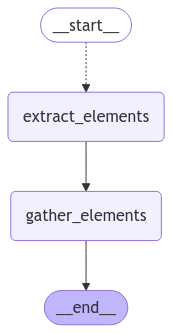

In [29]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [36]:
async for step in app.astream(
    {"contents": [(doc.page_content,doc.metadata["source"]) for doc in texts]},
):
    print(step)

ValueError: Unknown field for Schema: title

In [ ]:
texts[0]

Document(metadata={'source': 'D:\\my_study\\MAS_game\\agent_role.py', 'language': <Language.PYTHON: 'python'>}, page_content='from enum import Enum\n\nclass AgentRole(Enum):\n    STORYTELLER = "storyteller"\n    GAME_MASTER = "game_master"\n    CHARACTER = "character"\n    ADVISOR = "advisor"')